# Web scraper

Just change the LOCATION line so you can save it in your own directory!

In [ ]:
import requests
from bs4 import BeautifulSoup

# WEB SCRAPER
URL = 'http://web.mta.info/developers/turnstile.html'
URL2 = 'http://web.mta.info/developers/'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')

LOCATION = '' # ex: '/home/tomas/Documents/Fiverr/harpreetgaur/Data/'

links = soup.find_all('a')

files_names = []
for i in range(len(links)):
    a = links[i]
    date = a.decode_contents()
    if date[-4:] == '2013':
        files_names.append(date)
        link = URL2 + a['href']
        page = requests.get(link)
    
        soup = BeautifulSoup(page.content, 'lxml')
        
        content = soup.text
        
        f= open(LOCATION+date+'.csv',"w+")
        f.write(content)
        f.close()

f= open(LOCATION+'Files Names'+'.txt',"w+")
f.write(str(files_names))
f.close()

# Analysis

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.dpi'] = 100

LOCATION = '/home/tomas/Documents/Fiverr/harpreetgaur/Data/' # ex: '/home/tomas/Documents/Fiverr/harpreetgaur/Data/'

files_names = ['Saturday, December 28, 2013', 'Saturday, December 21, 2013', 'Saturday, December 14, 2013', 'Saturday, December 07, 2013',
 'Saturday, November 30, 2013', 'Saturday, November 23, 2013', 'Saturday, November 16, 2013', 'Saturday, November 09, 2013',
 'Saturday, November 02, 2013', 'Saturday, October 26, 2013', 'Saturday, October 19, 2013', 'Saturday, October 12, 2013',
 'Saturday, October 05, 2013', 'Saturday, September 28, 2013', 'Saturday, September 21, 2013', 'Saturday, September 14, 2013',
 'Saturday, September 07, 2013', 'Saturday, August 31, 2013', 'Saturday, August 24, 2013', 'Saturday, August 17, 2013',
 'Saturday, August 10, 2013', 'Saturday, August 03, 2013', 'Saturday, July 27, 2013', 'Saturday, July 20, 2013',
 'Saturday, July 13, 2013', 'Saturday, July 06, 2013', 'Saturday, June 29, 2013', 'Saturday, June 22, 2013',
 'Saturday, June 15, 2013', 'Saturday, June 08, 2013', 'Saturday, June 01, 2013', 'Saturday, May 25, 2013',
 'Saturday, May 18, 2013', 'Saturday, May 11, 2013', 'Saturday, May 04, 2013', 'Saturday, April 27, 2013',
 'Saturday, April 20, 2013', 'Saturday, April 13, 2013', 'Saturday, April 06, 2013', 'Saturday, March 30, 2013',
 'Saturday, March 23, 2013', 'Saturday, March 16, 2013', 'Saturday, March 09, 2013', 'Saturday, March 02, 2013',
 'Saturday, February 23, 2013', 'Saturday, February 16, 2013', 'Saturday, February 09, 2013', 'Saturday, February 02, 2013',
 'Saturday, January 26, 2013', 'Saturday, January 19, 2013', 'Saturday, January 12, 2013', 'Saturday, January 05, 2013']

columns = ['C/A','UNIT','SCP','DATE1','TIME1','DESC1','ENTRIES1','EXITS1','DATE2','TIME2','DESC2','ENTRIES2','EXITS2','DATE3','TIME3','DESC3','ENTRIES3','EXITS3','DATE4','TIME4','DESC4','ENTRIES4','EXITS4','DATE5','TIME5','DESC5','ENTRIES5','EXITS5','DATE6','TIME6','DESC6','ENTRIES6','EXITS6','DATE7','TIME7','DESC7','ENTRIES7','EXITS7','DATE8','TIME8','DESC8','ENTRIES8','EXITS8']


## Data cleaning

Here we are going to assign each row a station, and also get rid of the 'recovr aud'.

In [ ]:
station_loc = '' # location of the Remote-Booth-Station.csv file
                 # ex: '/home/tomas/Documents/Fiverr/harpreetgaur/Data/Remote-Booth-Station.csv'
station_csv = pd.read_csv(station_loc)

def assign_station(df, station_csv):
    station=[]
    station_csv = station_csv.dropna()
    for i in range(len(df)):
        unit = df.UNIT.values[i]
        ca = df['C/A'].values[i]
        a = station_csv[(station_csv['Remote']==unit) & (station_csv['Booth']==ca)]
        if not a.empty:
            station.append(a.Station.values[0])
        else:
            station.append(np.NaN)
    df['Station'] = station
    return df

def remove_recovr_aud():
    for i in range(len(files_names)):
        data = pd.read_csv(LOCATION + files_names[i] + '.csv', names=columns)
        data_ = assign_station(data, station_csv)
        data__ = data_[(data_['DESC1'] != 'RECOVR AUD') & (data_['DESC2'] != 'RECOVR AUD') & (data_['DESC3'] != 'RECOVR AUD')
        & (data_['DESC4'] != 'RECOVR AUD') & (data_['DESC5'] != 'RECOVR AUD') & (data_['DESC6'] != 'RECOVR AUD') & (data_['DESC7'] != 'RECOVR AUD')
        & (data_['DESC8'] != 'RECOVR AUD')]
        data__.to_csv(LOCATION + files_names[i] + '.csv')


remove_recovr_aud()

### Which station has the most number of units?

In [3]:
def station_list():
    asd_ = pd.concat([pd.read_csv(LOCATION + files_names[i] + '.csv') for i in range(len(files_names))], ignore_index=True)
    asd = asd_.drop(columns='Unnamed: 0')
    
    sum_ = asd.groupby(['Station']).UNIT.unique()
    stations = list(sum_.keys())
    unique = []
    for i in range(len(sum_)):
        unique.append(len(sum_[i]))
        
    return stations[unique.index(max(unique))]
    
print('The station that has the most number of units is: ' + str(station_list()))

The station that has the most number of units is: 86 ST


### What is the total number of entries & exits across the subway system for February 1, 2013?

In [16]:
feb = pd.read_csv(LOCATION + 'Saturday, February 02, 2013' + '.csv')


def exits(df, day):
    exits_ = []
    station_ = []
    stations = list(df['Station'].unique())
    hours = ['0'+str(i)+':00:00' for i in range(0, 4)]
    offset = []
    for j in range(len(stations)):
        df_temp = df[df['Station'] == stations[j]]
        exits_stat = []
        for i in range(2, len(df_temp)-1):
            k = np.nan
            for k_0 in range(1,9):
                for m in range(len(hours)):
                    if df_temp['DATE%s' % k_0].values[i] == day and df_temp['TIME%s' % k_0].values[i] == hours[m]:
                        k = k_0
                        break
            
            if not np.isnan(k):
                if k>1:
                        
                    kf = range(k+1, 9)
                    ki = range(1, k+1)
                    lst = [df['EXITS%s' % l][i] for l in kf if df['EXITS%s' % l][i]!=0] + [df['EXITS%s' % l][i+1] for l in ki if df['EXITS%s' % l][i+1]!=0 or df['EXITS%s' % l][i]!=np.nan]
                    exits_stat.append(sum(lst) - len(lst)*df['EXITS%s' % (k-1)][i])
                    offset.append(df['EXITS%s' % (k-1)][i])
                    break
                    
               
                elif k == 1:
                    lst = [df['EXITS%s' % l][i] for l in range(1, 9) if df['EXITS%s' % l][i]!=0 or df['EXITS%s' % l][i]!=np.nan] 
                    exits_stat.append(sum(lst) - len(lst)*df['EXITS8'][i-1])
                    offset.append(df['EXITS8'][i])
                    
                    break
        exits_.append(sum(exits_stat))
        station_.append(stations[j])
    exits = []
    station = []
    for i in range(len(exits_)):
        if abs(exits_[i]) < 10000000:
            exits.append(exits_[i])
            station.append(station_[i])
    return exits, offset, station

def entries(df, day):
    entries_ = []
    station_ = []
    stations = list(df['Station'].unique())
    hours = ['0'+str(i)+':00:00' for i in range(0, 4)]
    offset = []
    for j in range(len(stations)):
        df_temp = df[df['Station'] == stations[j]]
        entries_stat = []
        indxs = list(df_temp.index)
        for i in range(len(indxs)-1):
            k = np.nan
            for k_0 in range(1,9):
                for m in range(len(hours)):
                    if df_temp.loc[indxs[i], 'DATE%s' % k_0] == day and df_temp.loc[indxs[i], 'TIME%s' % k_0] == hours[m]:
                        k = k_0
                        break
            
            if not np.isnan(k):
                if k>1:
                        
                    kf = range(k+1, 9)
                    ki = range(1, k+1)
                    lst = [df_temp.loc[indxs[i], 'ENTRIES%s' % l] for l in kf if df_temp.loc[indxs[i], 'ENTRIES%s' % l]!=0] + [df_temp.loc[indxs[i+1], 'ENTRIES%s' % l] for l in ki if df_temp.loc[indxs[i+1], 'ENTRIES%s' % l]!=0 or df_temp.loc[indxs[i], 'ENTRIES%s' % l]!=np.nan]
                    entries_stat.append(sum(lst) - len(lst)*df_temp.loc[indxs[i], 'ENTRIES%s' % (k-1)])
                    offset.append(df_temp.loc[indxs[i], 'ENTRIES%s' % (k-1)])
                    break
                    
               
                elif k == 1:
                    lst = [df_temp.loc[indxs[i], 'ENTRIES%s' % l] for l in range(1, 9) if df_temp.loc[indxs[i], 'ENTRIES%s' % l]!=0 or df_temp.loc[indxs[i], 'ENTRIES%s' % l]!=np.nan] 
                    entries_stat.append(sum(lst) - len(lst)*df_temp.loc[indxs[i-1], 'ENTRIES8'])
                    offset.append(df_temp.loc[indxs[i], 'ENTRIES8'])
                    
                    break
        entries_.append(sum(entries_stat))
        station_.append(stations[j])
    entries = []
    station = []
    for i in range(len(entries_)):
        if abs(entries_[i]) < 10000000:
            entries.append(entries_[i])
            station.append(station_[i])
    return entries, offset, station
    
entries_01, entries_31, stations_ent = entries(feb, '02-01-13')
exits_01, exits_31, stations_ex = exits(feb, '02-01-13')

print('Total number of entries for Febraury 1: ' + str(sum(entries_01)))
print('Total number of exits for Febraury 1: ' + str(sum(exits_01)))

Total number of entries for Febraury 1: 7281223.0
Total number of exits for Febraury 1: 323351.0


### Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?

In [17]:
business = [entries_01[i] + exits_01[i] for i in range(len(entries_01))]
ind = business.index(max(business))
print('The bussiest station on 1 Feb was: ' + str(stations_ent[ind]))

The bussiest station on 1 Feb was: AVE U


In [28]:
feb = pd.read_csv(LOCATION + 'Saturday, February 02, 2013' + '.csv')


def exits(df, day):
    exits_ = []
    station_ = []
    stations = list(df['SCP'].unique())
    hours = ['0'+str(i)+':00:00' for i in range(0, 4)]
    offset = []
    for j in range(len(stations)):
        df_temp = df[df['SCP'] == stations[j]]
        exits_stat = []
        for i in range(2, len(df_temp)-1):
            k = np.nan
            for k_0 in range(1,9):
                for m in range(len(hours)):
                    if df_temp['DATE%s' % k_0].values[i] == day and df_temp['TIME%s' % k_0].values[i] == hours[m]:
                        k = k_0
                        break
            
            if not np.isnan(k):
                if k>1:
                        
                    kf = range(k+1, 9)
                    ki = range(1, k+1)
                    lst = [df['EXITS%s' % l][i] for l in kf if df['EXITS%s' % l][i]!=0] + [df['EXITS%s' % l][i+1] for l in ki if df['EXITS%s' % l][i+1]!=0 or df['EXITS%s' % l][i]!=np.nan]
                    exits_stat.append(sum(lst) - len(lst)*df['EXITS%s' % (k-1)][i])
                    offset.append(df['EXITS%s' % (k-1)][i])
                    break
                    
               
                elif k == 1:
                    lst = [df['EXITS%s' % l][i] for l in range(1, 9) if df['EXITS%s' % l][i]!=0 or df['EXITS%s' % l][i]!=np.nan] 
                    exits_stat.append(sum(lst) - len(lst)*df['EXITS8'][i-1])
                    offset.append(df['EXITS8'][i])
                    
                    break
        exits_.append(sum(exits_stat))
        station_.append(stations[j])
    exits = []
    station = []
    for i in range(len(exits_)):
        if abs(exits_[i]) < 10000000:
            exits.append(exits_[i])
            station.append(station_[i])
    return exits, offset, station

def entries(df, day):
    entries_ = []
    station_ = []
    stations = list(df['SCP'].unique())
    hours = ['0'+str(i)+':00:00' for i in range(0, 4)]
    offset = []
    for j in range(len(stations)):
        df_temp = df[df['SCP'] == stations[j]]
        entries_stat = []
        indxs = list(df_temp.index)
        for i in range(len(indxs)-1):
            k = np.nan
            for k_0 in range(1,9):
                for m in range(len(hours)):
                    if df_temp.loc[indxs[i], 'DATE%s' % k_0] == day and df_temp.loc[indxs[i], 'TIME%s' % k_0] == hours[m]:
                        k = k_0
                        break
            
            if not np.isnan(k):
                if k>1:
                        
                    kf = range(k+1, 9)
                    ki = range(1, k+1)
                    lst = [df_temp.loc[indxs[i], 'ENTRIES%s' % l] for l in kf if df_temp.loc[indxs[i], 'ENTRIES%s' % l]!=0] + [df_temp.loc[indxs[i+1], 'ENTRIES%s' % l] for l in ki if df_temp.loc[indxs[i+1], 'ENTRIES%s' % l]!=0 or df_temp.loc[indxs[i], 'ENTRIES%s' % l]!=np.nan]
                    entries_stat.append(sum(lst) - len(lst)*df_temp.loc[indxs[i], 'ENTRIES%s' % (k-1)])
                    offset.append(df_temp.loc[indxs[i], 'ENTRIES%s' % (k-1)])
                    break
                    
               
                elif k == 1:
                    lst = [df_temp.loc[indxs[i], 'ENTRIES%s' % l] for l in range(1, 9) if df_temp.loc[indxs[i], 'ENTRIES%s' % l]!=0 or df_temp.loc[indxs[i], 'ENTRIES%s' % l]!=np.nan] 
                    entries_stat.append(sum(lst) - len(lst)*df_temp.loc[indxs[i-1], 'ENTRIES8'])
                    offset.append(df_temp.loc[indxs[i], 'ENTRIES8'])
                    
                    break
        entries_.append(sum(entries_stat))
        station_.append(stations[j])
    entries = []
    station = []
    for i in range(len(entries_)):
        if abs(entries_[i]) < 10000000:
            entries.append(entries_[i])
            station.append(station_[i])
    return entries, offset, station
    
entries_01, entries_31, stations_ent = entries(feb, '02-01-13')
exits_01, exits_31, stations_ex = exits(feb, '02-01-13')

business = [entries_01[i] + exits_01[i] for i in range(len(entries_01))]

ind = business.index(max(business))

print('The bussiest turnstile on 1 Feb was: ' + str(stations_ent[ind]))

The bussiest turnstile on 1 Feb was: 03-00-03


### Some usefull functions
This functions will eliminate the cumulative factor in the entries/exits columns.

In [6]:
def total_entries(data):
    df = data.copy()
    indexs = list(df.index)
    for i in range(len(indexs)):
        for k in range(1,9):
            if not np.isnan(df.loc[indexs[i], 'ENTRIES%s' % (k)]):
                if k>1:
                    point = df.at[indexs[i], 'ENTRIES%s' % (k)] - df.at[indexs[i], 'ENTRIES%s' % (k-1)]
                    if point > 0 and point < 100000: 
                        df.at[indexs[i], 'ENTRIES%s' % (k)] = point
                    else:
                        df.at[indexs[i], 'ENTRIES%s' % (k)]  = 0
                elif k == 1 and indexs[i] == indexs[i-1]+1:
                    try:
                        point = df.at[indexs[i], 'ENTRIES1'] - df.at[indexs[i-1], 'ENTRIES8']
                        if point < 100000 and point > 0 :
                            df.at[indexs[i], 'ENTRIES1'] = point
                        else:
                            df.at[indexs[i], 'ENTRIES1'] = 0
                    except KeyError:
                        continue
    return df



def total_exits(data):
    df = data.copy()
    indexs = list(df.index)
    for i in range(len(indexs)):
        for k in range(1,9):
            if not np.isnan(df.loc[indexs[i], 'ENTRIES%s' % (k)]):
                if k>1:
                    point = df.at[indexs[i], 'EXITS%s' % (k)] - df.at[indexs[i], 'EXITS%s' % (k-1)]
                    if point > 0 and point < 100000: 
                        df.at[indexs[i], 'EXITS%s' % (k)] = point
                    else:
                        df.at[indexs[i], 'EXITS%s' % (k)]  = 0
                elif k == 1 and indexs[i] == indexs[i-1]+1  :
                    try:
                        point = df.at[indexs[i], 'EXITS1'] - df.at[indexs[i-1], 'EXITS8']
                        if point < 100000 and point > 0 :
                            df.at[indexs[i], 'EXITS1'] = point
                        else:
                            df.at[indexs[i], 'EXITS1'] = 0
                    except KeyError:
                        continue

    return df

def filter_(df):
    for i in range(len(df)):
        if abs(df[i]) > 1000000:
            df[i] = df[i+1]
    return df

### What stations have seen the most usage growth/decline in 2013?

We define the growth (decline) of usage in a station as the ratio between the mean of the 3 first (last) weeks with the 3 last (first). 

If the growth is >5, then that station is included in the most growth usage.

If the decline is <1, then that station is included in the most decline usage.

In [7]:
def usage_station():
    data_ = pd.concat([pd.read_csv(LOCATION + files_names[i] + '.csv') for i in range(len(files_names))], ignore_index=True)
    data_ = data_.drop(columns='Unnamed: 0')
    stations = list(data_['Station'].unique())
    business = []

    for j in range(len(stations)):
        data = data_[data_.Station == stations[j]]
        data = total_entries(data)
        data = total_exits(data)
        
        suma_ent = data.groupby(['DATE1']).ENTRIES1.sum()  + data.groupby(['DATE1']).ENTRIES2.sum() + data.groupby(['DATE1']).ENTRIES3.sum() + data.groupby(['DATE1']).ENTRIES4.sum() + data.groupby(['DATE1']).ENTRIES5.sum() + data.groupby(['DATE1']).ENTRIES6.sum() + data.groupby(['DATE1']).ENTRIES7.sum() + data.groupby(['DATE1']).ENTRIES8.sum()
        suma_ex = data.groupby(['DATE1']).EXITS1.sum()  + data.groupby(['DATE1']).EXITS2.sum() + data.groupby(['DATE1']).EXITS3.sum() + data.groupby(['DATE1']).EXITS4.sum() + data.groupby(['DATE1']).EXITS5.sum() + data.groupby(['DATE1']).EXITS6.sum() + data.groupby(['DATE1']).EXITS7.sum() + data.groupby(['DATE1']).EXITS8.sum()
        
        business.append([suma_ent[i] + suma_ex[i] for i in range(len(suma_ent))])

    return business, stations


business, stations = usage_station()
growth = []
decline = []
for i in range(len(business)):
    if len(business[i]) > 7:
        initial = np.mean(business[i][0:3])
        final = np.mean(business[i][-4:-1])
        if initial/final > 5 and final != 0:
            growth.append(stations[i])
        elif final/initial > 2 and initial != 0:
            decline.append(stations[i])
        
print('/////')
print('The stations that have seen the most usage growth in 2013 are: ' + str(growth))
print('/////')
print('The stations that have seen the most usage decline in 2013 are: ' + str(decline))
print('/////')

/////
The stations that have seen the most usage growth in 2013 are: ['BROAD ST', 'BOTANIC GARDEN', 'NEWKIRK AVE', '36 ST', '8 AVE', 'NEW UTRECHT AVE', '20 AVE', 'STILLWELL AVE', 'ROCKAWAY PKY', 'FRESH POND ROAD', 'W 4 ST-WASH SQ', 'UTICA AVE', 'ROCKAWAY PK 116', 'KINGSBRIDGE RD', '7 AVE-53 ST', '5 AVE-53 ST', 'QUEENS PLAZA', 'NORTHERN BLVD', 'MYRTLE-WILLOUGH', '2 AVE', 'HOUSTON ST', 'E TREMONT AVE', 'E 177 ST-PARKCH']
/////
The stations that have seen the most usage decline in 2013 are: ['LEXINGTON AVE', '5 AVE-59 ST', '49 ST-7 AVE', '42 ST-TIMES SQ', '34 ST-HERALD SQ', '23 ST-5 AVE', '14 ST-UNION SQ', "PRINCE ST-B'WAY", 'CANAL ST', "MURRAY ST-B'WAY", 'CORTLANDT ST', 'RECTOR ST', 'CHAMBERS ST', '7 AVE', 'PROSPECT PARK', 'CHURCH AVE', 'AVE J', 'AVE U', 'OCEAN PARKWAY', 'BOROUGH HALL/CT', 'JAY ST-METROTEC', 'DEKALB AVE', 'PACIFIC ST', '9 ST', '25 ST', '59 ST', '86 ST', 'BAY RIDGE-95 ST', '18 AVE', 'BAY PKY-22 AVE', '50 ST', 'BAY PARKWAY', 'W 8 ST-AQUARIUM', '6 AVE', 'LORIMER ST', 'GRAND

/usr/lib/python3/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


### What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?


In [8]:
def busy_days():
    data = pd.concat([pd.read_csv(LOCATION + files_names[i] + '.csv') for i in range(len(files_names))], ignore_index=True)
    data = data.drop(columns='Unnamed: 0')

    data = total_entries(data)
    data = total_exits(data)
    
    suma_ent = data.groupby(['DATE1']).ENTRIES1.sum()  + data.groupby(['DATE1']).ENTRIES2.sum() + data.groupby(['DATE1']).ENTRIES3.sum() + data.groupby(['DATE1']).ENTRIES4.sum() + data.groupby(['DATE1']).ENTRIES5.sum() + data.groupby(['DATE1']).ENTRIES6.sum() + data.groupby(['DATE1']).ENTRIES7.sum() + data.groupby(['DATE1']).ENTRIES8.sum()
    suma_ex = data.groupby(['DATE1']).EXITS1.sum()  + data.groupby(['DATE1']).EXITS2.sum() + data.groupby(['DATE1']).EXITS3.sum() + data.groupby(['DATE1']).EXITS4.sum() + data.groupby(['DATE1']).EXITS5.sum() + data.groupby(['DATE1']).EXITS6.sum() + data.groupby(['DATE1']).EXITS7.sum() + data.groupby(['DATE1']).EXITS8.sum()
    
    business = [suma_ent[i] + suma_ex[i] for i in range(len(suma_ent))]
    
    mean = np.mean(business)
    std = np.std(business)
    least_use = []

    for i in range(len(business)):
        if business[i] < mean - std:
            least_use.append(suma_ent.keys()[i])


    return print('Least busy days: ' + str(least_use))

def closed_days():
    data = pd.concat([pd.read_csv(LOCATION + files_names[i] + '.csv') for i in range(len(files_names))], ignore_index=True)
    data = data.drop(columns='Unnamed: 0')
    stations = list(data.Station.unique())
    for j in range(len(stations)):
        data = data[data.Station == stations[j]]
        data = total_entries(data)
        data = total_exits(data)
        
        suma_ent = data.groupby(['DATE1']).ENTRIES1.sum()  + data.groupby(['DATE1']).ENTRIES2.sum() + data.groupby(['DATE1']).ENTRIES3.sum() + data.groupby(['DATE1']).ENTRIES4.sum() + data.groupby(['DATE1']).ENTRIES5.sum() + data.groupby(['DATE1']).ENTRIES6.sum() + data.groupby(['DATE1']).ENTRIES7.sum() + data.groupby(['DATE1']).ENTRIES8.sum()
        suma_ex = data.groupby(['DATE1']).EXITS1.sum()  + data.groupby(['DATE1']).EXITS2.sum() + data.groupby(['DATE1']).EXITS3.sum() + data.groupby(['DATE1']).EXITS4.sum() + data.groupby(['DATE1']).EXITS5.sum() + data.groupby(['DATE1']).EXITS6.sum() + data.groupby(['DATE1']).EXITS7.sum() + data.groupby(['DATE1']).EXITS8.sum()
        
        business = [suma_ent[i] + suma_ex[i] for i in range(len(suma_ent))]
        

        mean = np.mean(business)
        least_use = []
        cero_use = []
        for i in range(len(business)):
            if business[i] < 0.05*mean:
                least_use.append(suma_ent.keys()[i])

            if business[i] == 0.0:
                cero_use.append(suma_ent.keys()[i])

    return print('Station not operating at full capacity days: ' + str(least_use)), print('Station closed entirely days: ' + str(set(cero_use)))

print('/////')
busy_days()
print('/////')
closed_days()
print('/////')

/////
Least busy days: ['01-01-13', '01-04-13', '01-08-13', '01-11-13', '01-18-13', '01-22-13', '01-25-13', '02-01-13', '02-08-13', '02-12-13', '02-15-13', '02-19-13', '02-22-13', '03-01-13', '03-08-13', '03-15-13', '04-26-13', '05-17-13', '05-24-13', '05-28-13', '05-31-13', '06-07-13', '06-11-13', '06-21-13', '06-28-13', '07-12-13', '07-19-13', '07-26-13', '08-02-13', '08-06-13', '08-09-13', '08-16-13', '08-23-13', '08-30-13', '09-06-13', '09-10-13', '09-13-13', '09-20-13', '09-27-13', '10-04-13', '10-11-13', '10-18-13', '10-22-13', '10-25-13', '11-08-13', '11-12-13', '11-15-13', '11-22-13', '11-26-13', '11-29-13', '12-06-13', '12-13-13', '12-17-13', '12-20-13', '12-24-13', '12-27-13']
/////


/home/tomas/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tomas/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Station not operating at full capacity days: []
Station closed entirely days: set()
/////


## Plots

### Plot daily row count

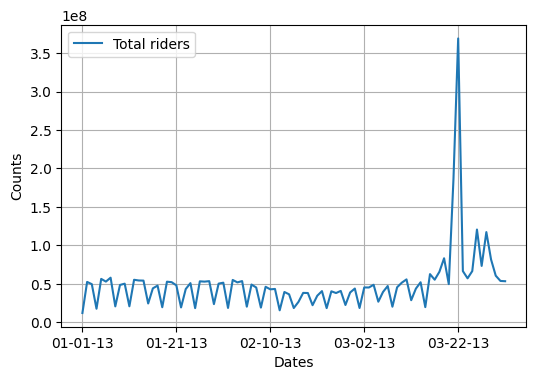

In [19]:
Q_1 = list(reversed(['Saturday, March 30, 2013', 'Saturday, March 23, 2013', 'Saturday, March 16, 2013', 'Saturday, March 09, 2013', 'Saturday, March 02, 2013',
 'Saturday, February 23, 2013', 'Saturday, February 16, 2013', 'Saturday, February 09, 2013', 'Saturday, February 02, 2013',
 'Saturday, January 26, 2013', 'Saturday, January 19, 2013', 'Saturday, January 12, 2013', 'Saturday, January 05, 2013']))

def plot_1():
    data = pd.concat([pd.read_csv(LOCATION + Q_1[i] + '.csv') for i in range(len(Q_1))], ignore_index=True)
    data = data.drop(columns='Unnamed: 0')
    data = total_entries(data)
    
    suma_ent = data.groupby(['DATE1']).ENTRIES1.sum()  + data.groupby(['DATE1']).ENTRIES2.sum() + data.groupby(['DATE1']).ENTRIES3.sum() + data.groupby(['DATE1']).ENTRIES4.sum() + data.groupby(['DATE1']).ENTRIES5.sum() + data.groupby(['DATE1']).ENTRIES6.sum() + data.groupby(['DATE1']).ENTRIES7.sum() + data.groupby(['DATE1']).ENTRIES8.sum()

    plt.figure(1)
    suma_ent.plot(label='Total riders')
    plt.xlabel('Dates')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()

plot_1()

###  Plot the daily total number of entries & exits across the system for Q1 2013.

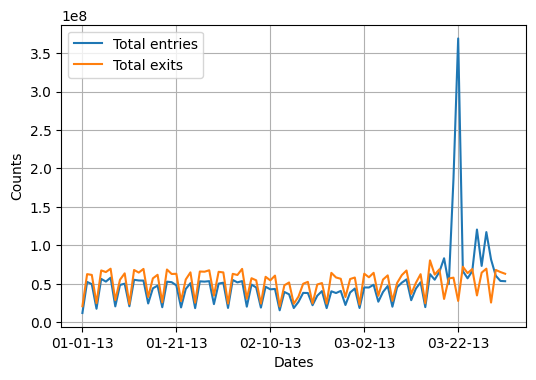

In [20]:
Q_1 = list(reversed(['Saturday, March 30, 2013', 'Saturday, March 23, 2013', 'Saturday, March 16, 2013', 'Saturday, March 09, 2013', 'Saturday, March 02, 2013',
 'Saturday, February 23, 2013', 'Saturday, February 16, 2013', 'Saturday, February 09, 2013', 'Saturday, February 02, 2013',
 'Saturday, January 26, 2013', 'Saturday, January 19, 2013', 'Saturday, January 12, 2013', 'Saturday, January 05, 2013']))

def plot_2():
    data = pd.concat([pd.read_csv(LOCATION + Q_1[i] + '.csv') for i in range(len(Q_1))], ignore_index=True)
    data = data.drop(columns='Unnamed: 0')
    data = total_entries(data)
    data = total_exits(data)
    
    suma_ent = data.groupby(['DATE1']).ENTRIES1.sum()  + data.groupby(['DATE1']).ENTRIES2.sum() + data.groupby(['DATE1']).ENTRIES3.sum() + data.groupby(['DATE1']).ENTRIES4.sum() + data.groupby(['DATE1']).ENTRIES5.sum() + data.groupby(['DATE1']).ENTRIES6.sum() + data.groupby(['DATE1']).ENTRIES7.sum() + data.groupby(['DATE1']).ENTRIES8.sum()
    suma_ex = data.groupby(['DATE1']).EXITS1.sum()  + data.groupby(['DATE1']).EXITS2.sum() + data.groupby(['DATE1']).EXITS3.sum() + data.groupby(['DATE1']).EXITS4.sum() + data.groupby(['DATE1']).EXITS5.sum() + data.groupby(['DATE1']).EXITS6.sum() + data.groupby(['DATE1']).EXITS7.sum() + data.groupby(['DATE1']).EXITS8.sum()

    plt.figure(1)
    suma_ent.plot(label='Total entries')
    suma_ex.plot(label='Total exits')
    plt.xlabel('Dates')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()

plot_2()

### Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.


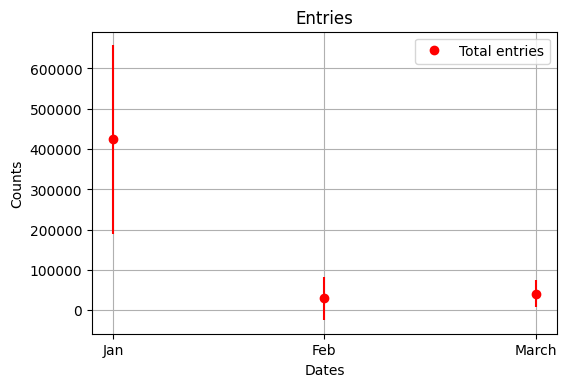

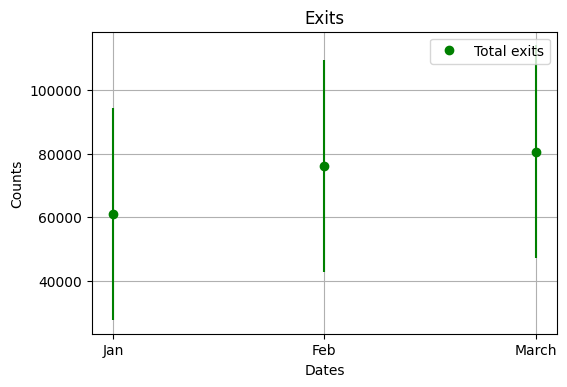

In [21]:
Q_1_3 = list(reversed(['Saturday, March 30, 2013', 'Saturday, March 23, 2013', 'Saturday, March 16, 2013', 'Saturday, March 09, 2013', 'Saturday, March 02, 2013']))
Q_1_2 = list(reversed(['Saturday, February 23, 2013', 'Saturday, February 16, 2013', 'Saturday, February 09, 2013', 'Saturday, February 02, 2013']))
Q_1_1 = list(reversed(['Saturday, January 26, 2013', 'Saturday, January 19, 2013', 'Saturday, January 12, 2013', 'Saturday, January 05, 2013']))



def plot_3():
    lst = [Q_1_1, Q_1_2, Q_1_3]
    lst_str = ['Jan', 'Feb', 'March']
    plt.figure(1)
    for j in range(len(lst)):
        data = pd.concat([pd.read_csv(LOCATION + lst[j][i] + '.csv', parse_dates=['DATE%s' % k for k in range(1, 9)], infer_datetime_format=True) for i in range(len(Q_1_1))], ignore_index=True)
        data = data.drop(columns='Unnamed: 0')
        data = data[data['Station'] == '34 ST-PENN STA']
        data = total_entries(data)
    
        suma_ent = data.groupby(['DATE1']).ENTRIES1.sum()  + data.groupby(['DATE1']).ENTRIES2.sum() + data.groupby(['DATE1']).ENTRIES3.sum() + data.groupby(['DATE1']).ENTRIES4.sum() + data.groupby(['DATE1']).ENTRIES5.sum() + data.groupby(['DATE1']).ENTRIES6.sum() + data.groupby(['DATE1']).ENTRIES7.sum() + data.groupby(['DATE1']).ENTRIES8.sum()
    
        suma_ent = filter_(suma_ent)
        
        plt.plot(j, np.mean(suma_ent.values), 'ro')
        plt.errorbar(j,  np.mean(suma_ent.values), yerr=np.std(suma_ent.values), ecolor='r')
    plt.xticks(range(len(lst)), lst_str)
    plt.xlabel('Dates')
    plt.ylabel('Counts')
    plt.legend(['Total entries'])
    plt.grid()
    plt.title('Entries')
    
    plt.figure(2)
    for j in range(len(lst)):
        data = pd.concat([pd.read_csv(LOCATION + lst[j][i] + '.csv', parse_dates=['DATE%s' % k for k in range(1, 9)], infer_datetime_format=True) for i in range(len(Q_1_1))], ignore_index=True)
        data = data.drop(columns='Unnamed: 0')
        data = data[data['Station'] == '34 ST-PENN STA']
        data = total_exits(data)
    
        suma_ex = data.groupby(['DATE1']).EXITS1.sum()  + data.groupby(['DATE1']).EXITS2.sum() + data.groupby(['DATE1']).EXITS3.sum() + data.groupby(['DATE1']).EXITS4.sum() + data.groupby(['DATE1']).EXITS5.sum() + data.groupby(['DATE1']).EXITS6.sum() + data.groupby(['DATE1']).EXITS7.sum() + data.groupby(['DATE1']).EXITS8.sum()
    
        suma_ex = filter_(suma_ex)
        
        plt.plot(j, np.mean(suma_ex.values), 'go')
        plt.errorbar(j,  np.mean(suma_ex.values), yerr=np.std(suma_ent.values), ecolor='g')
    plt.xticks(range(len(lst)), lst_str)
    plt.xlabel('Dates')
    plt.ylabel('Counts')
    plt.legend(['Total exits'])
    plt.grid()
    plt.title('Exits')

plot_3()

### Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.


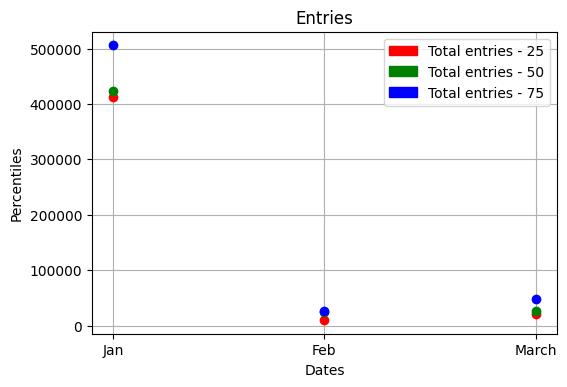

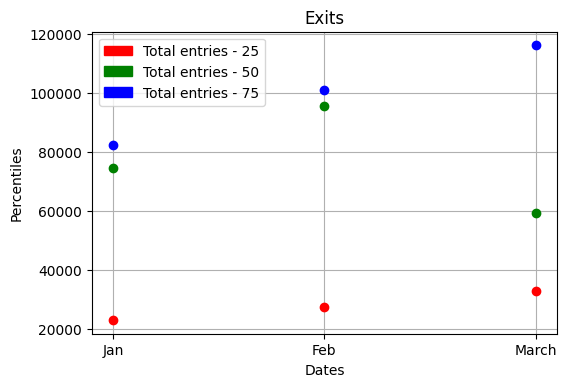

In [27]:
import matplotlib.patches as mpatches

Q_1_3 = list(reversed(['Saturday, March 30, 2013', 'Saturday, March 23, 2013', 'Saturday, March 16, 2013', 'Saturday, March 09, 2013', 'Saturday, March 02, 2013']))
Q_1_2 = list(reversed(['Saturday, February 23, 2013', 'Saturday, February 16, 2013', 'Saturday, February 09, 2013', 'Saturday, February 02, 2013']))
Q_1_1 = list(reversed(['Saturday, January 26, 2013', 'Saturday, January 19, 2013', 'Saturday, January 12, 2013', 'Saturday, January 05, 2013']))

percents = [25, 50, 75]

def plot_4():
    lst = [Q_1_1, Q_1_2, Q_1_3]
    lst_str = ['Jan', 'Feb', 'March']
    plt.figure(1)
    for j in range(len(lst)):
        data = pd.concat([pd.read_csv(LOCATION + lst[j][i] + '.csv', parse_dates=['DATE%s' % k for k in range(1, 9)], infer_datetime_format=True) for i in range(len(Q_1_1))], ignore_index=True)
        data = data.drop(columns='Unnamed: 0')
        data = data[data['Station'] == '34 ST-PENN STA']
        data = total_entries(data)
        data = total_exits(data)
    
        suma_ent = data.groupby(['DATE1']).ENTRIES1.sum()  + data.groupby(['DATE1']).ENTRIES2.sum() + data.groupby(['DATE1']).ENTRIES3.sum() + data.groupby(['DATE1']).ENTRIES4.sum() + data.groupby(['DATE1']).ENTRIES5.sum() + data.groupby(['DATE1']).ENTRIES6.sum() + data.groupby(['DATE1']).ENTRIES7.sum() + data.groupby(['DATE1']).ENTRIES8.sum()
    
        suma_ent = filter_(suma_ent)
        
        plt.plot(j, np.percentile(suma_ent.values, 25), 'ro')
        plt.plot(j, np.percentile(suma_ent.values, 50), 'go')
        plt.plot(j, np.percentile(suma_ent.values, 75), 'bo')
    plt.xticks(range(len(lst)), lst_str)
    plt.xlabel('Dates')
    plt.ylabel('Percentiles')
    red_patch = mpatches.Patch(color='red', label='Total entries - 25')
    green_patch = mpatches.Patch(color='green', label='Total entries - 50')
    blue_patch = mpatches.Patch(color='blue', label='Total entries - 75')
    plt.legend(handles=[red_patch, green_patch, blue_patch])
    plt.title('Entries')
    plt.grid()
    
    plt.figure(2)
    for j in range(len(lst)):
        data = pd.concat([pd.read_csv(LOCATION + lst[j][i] + '.csv', parse_dates=['DATE%s' % k for k in range(1, 9)], infer_datetime_format=True) for i in range(len(Q_1_1))], ignore_index=True)
        data = data.drop(columns='Unnamed: 0')
        data = data[data['Station'] == '34 ST-PENN STA']
        data = total_entries(data)
        data = total_exits(data)
    
        suma_ex = data.groupby(['DATE1']).EXITS1.sum()  + data.groupby(['DATE1']).EXITS2.sum() + data.groupby(['DATE1']).EXITS3.sum() + data.groupby(['DATE1']).EXITS4.sum() + data.groupby(['DATE1']).EXITS5.sum() + data.groupby(['DATE1']).EXITS6.sum() + data.groupby(['DATE1']).EXITS7.sum() + data.groupby(['DATE1']).EXITS8.sum()
    
        suma_ex = filter_(suma_ex)

        plt.plot(j, np.percentile(suma_ex.values, 25), 'ro')
        plt.plot(j, np.percentile(suma_ex.values, 50), 'go')
        plt.plot(j, np.percentile(suma_ex.values, 75), 'bo')
    plt.xticks(range(len(lst)), lst_str)
    plt.xlabel('Dates')
    plt.ylabel('Percentiles')
    red_patch = mpatches.Patch(color='red', label='Total entries - 25')
    green_patch = mpatches.Patch(color='green', label='Total entries - 50')
    blue_patch = mpatches.Patch(color='blue', label='Total entries - 75')
    plt.legend(handles=[red_patch, green_patch, blue_patch])
    plt.title('Exits')
    plt.grid()
    
plot_4()